In [2]:
import warnings
warnings.filterwarnings('ignore')

import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 5)})

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

import statsmodels.api as sm 

import scipy.stats as stats

In [3]:
# Read File
df_bike = pd.read_csv('https://ml-course2-upgrad.s3.amazonaws.com/Linear+Regression+Assignment/Bike+Sharing+Assignment/day.csv')
df_bike.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

## Data Dictionary -
 1. cnt is the dependent variable
 
 2. casual + registered = cnt 
 
 3. instant - record index (key field)
 
 4. dteday - date 
 
 5. season - 1:spring, 2:summer, 3:fall, 4:winter
 
 6. yr - 0: 2018, 1:2019
 
 7. mnth - 1 to 12
 
 8. holiday - 0: no, 1: yes
 
 9. weekday - 0 to 6 (6 and 0 is not a working day => 0 - Sunday to 6 - Saturday)
 
 10. workingday - if day is neither weekend nor holiday is 1, otherwise is 0.
 
 11. weathersit - 1 to 4 (ranked categorical? -> there are overlaps but it seems to be getting "worse" with rank)     
                      
 12. temp - temperature in celcius
 
 13. atemp - feeling temperature in celcius
 
 14. hum, windspeed 

In [4]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


No null values => no imputation

In [5]:
# converting date 
df_bike['dteday'] = pd.to_datetime(df_bike["dteday"])
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

But we already have month and year spearately => maybe, drop this

In [6]:
df_bike.shape

(730, 16)

In [7]:
df_bike.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

Range of columns varied => normalisation is required

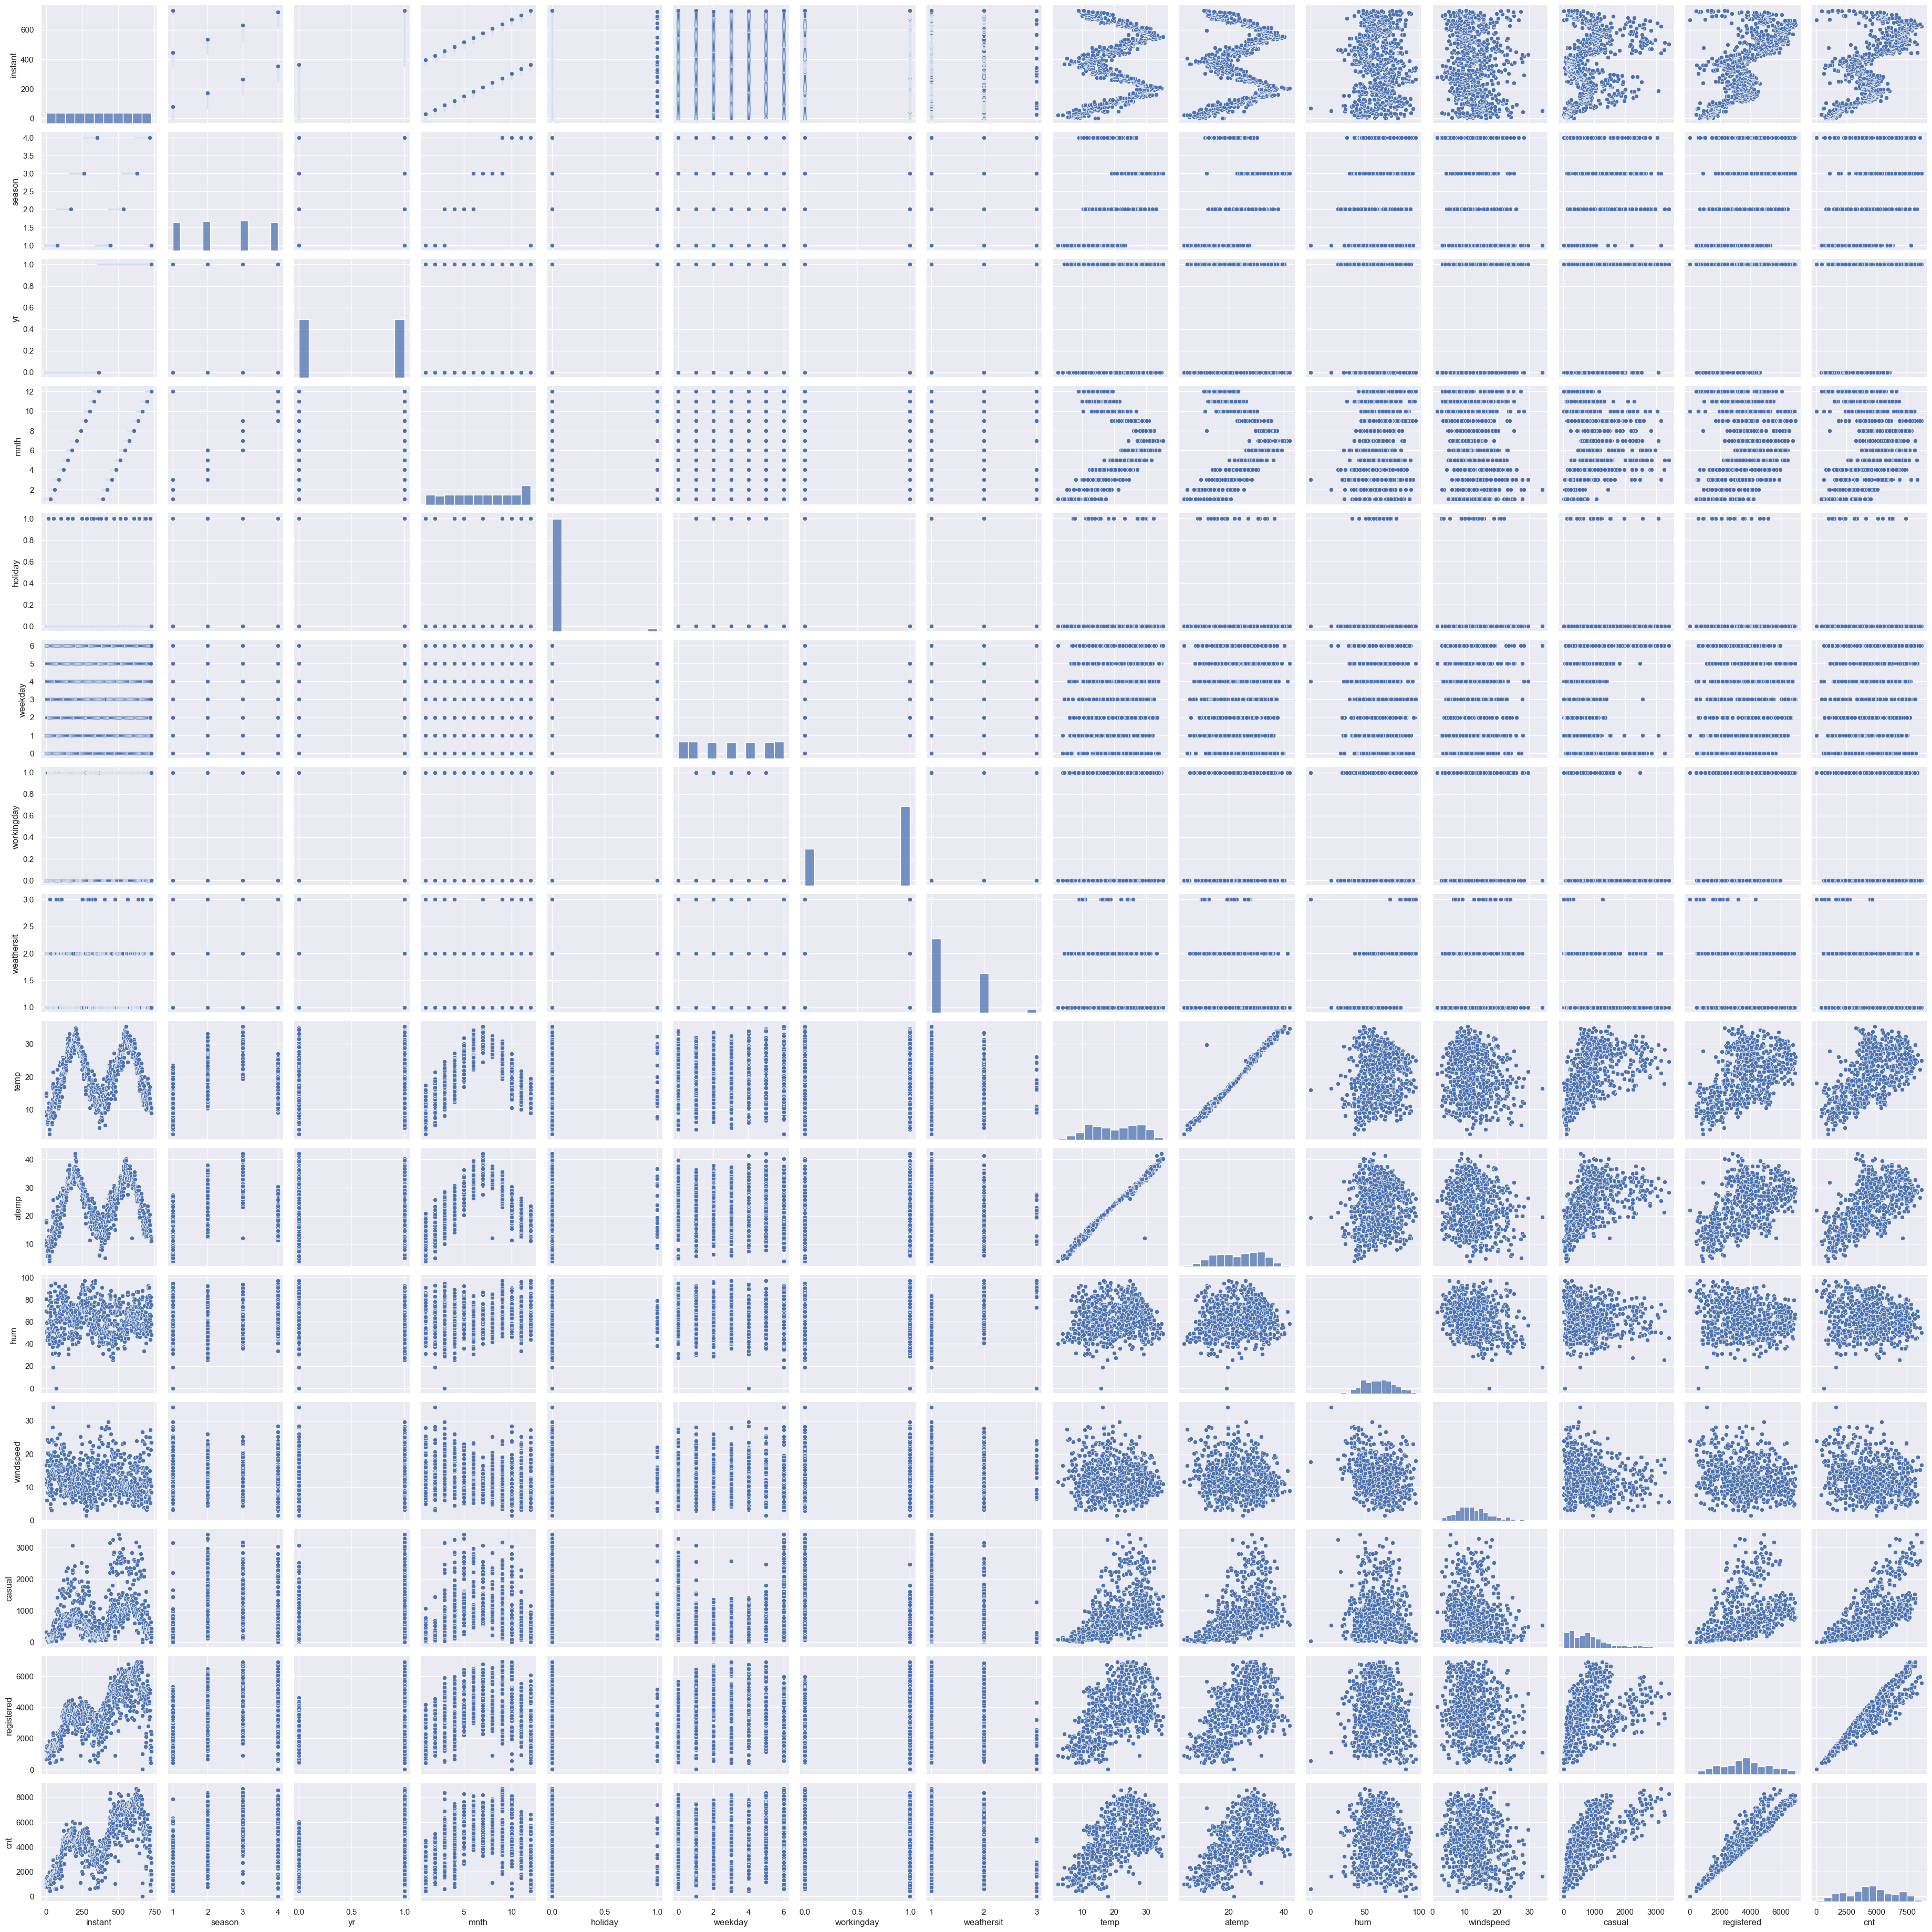

In [8]:
sns.pairplot(df_bike)
plt.show()

There are many observable linear relationships - We can apply MLR (Assumption of MLR -> Linearity satisfied)

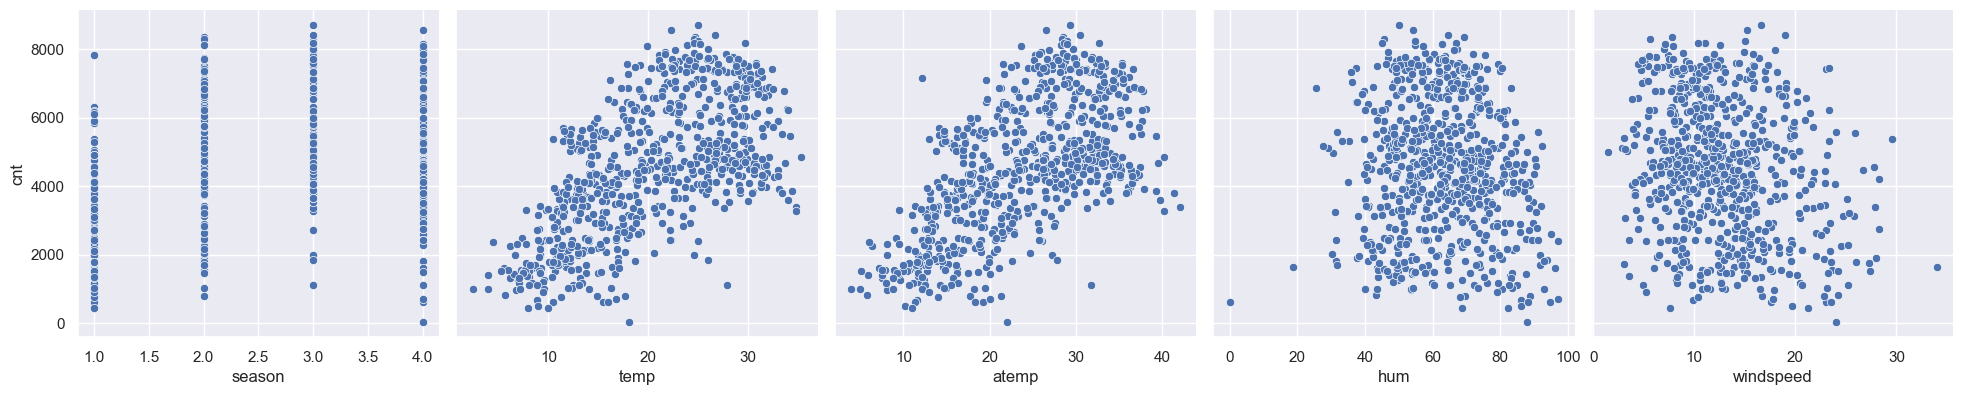

In [9]:
sns.pairplot(df_bike, x_vars=['season', 'temp', 'atemp', 'hum', 'windspeed'], y_vars='cnt',size=4, aspect=1, kind='scatter')
plt.show()

### Observations
- There seems to be a positive correlation between the number of bike rentals and temperature (and feeling temperature)

- There could be a very slight negative correlation between the number of bike rentals and (humidity and windspeed)

- Higher temperatures => more bike rentals

- Lower humidity => more bike rentals

- Lower wind speeds => more bike rentals

<Axes: >

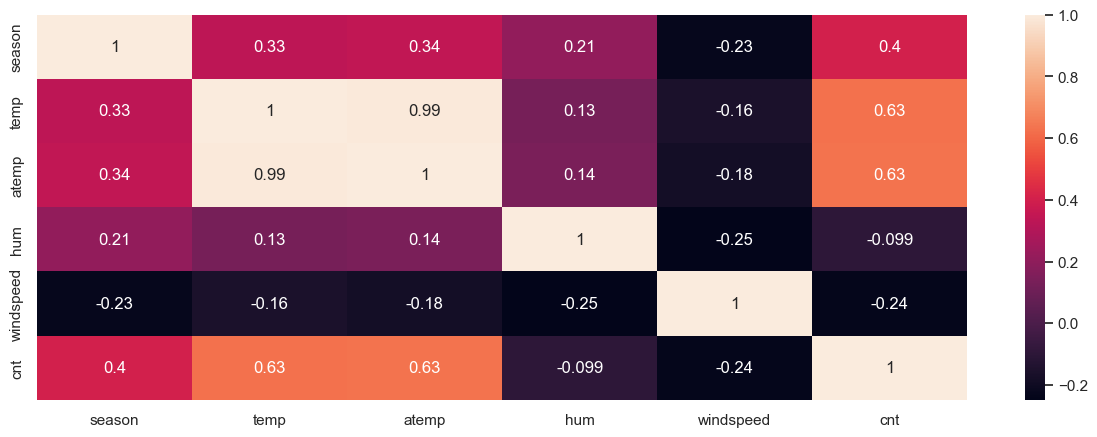

In [10]:
df_bike_eda = df_bike[['season', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
sns.heatmap(df_bike_eda.corr(), annot = True)

### Observations -
- temp and atemp has a perfect positive correlation/ collinear (almost approaching singularity)
- drop any one - drop temp as atemp is the feeling temperature and 
- this will impact the riders choosing to rent a bike

<Axes: xlabel='weathersit', ylabel='cnt'>

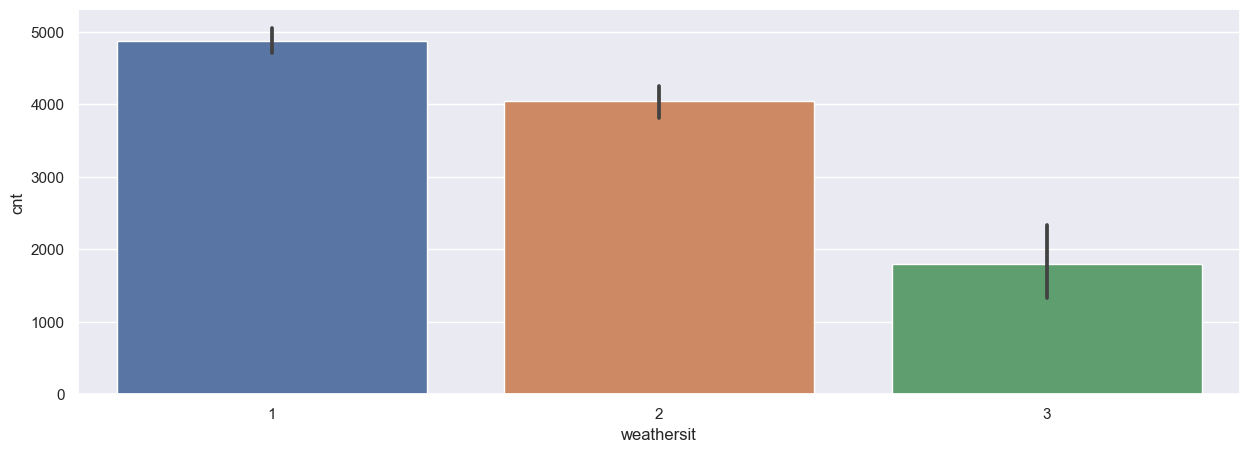

In [11]:
sns.barplot(x='weathersit', y='cnt', data = df_bike)

### Data dictionary for reference -
- weathersit - 1 to 4 (considering as ranked categorical)

- When weather gets worse, lesser rentals

- No rentals at 4 (most adverse weather)

<Axes: >

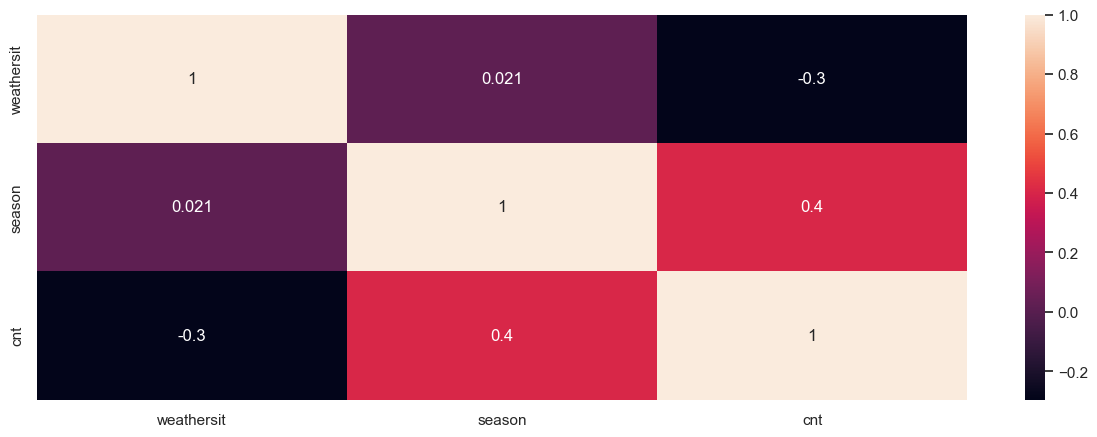

In [12]:
df_bike_eda = df_bike[['weathersit', 'season', 'cnt']]
sns.heatmap(df_bike_eda.corr(), annot = True)

Though there seemed to be a good negative correlation in the plot, the correlation coefficient shows only a slight negative correlation

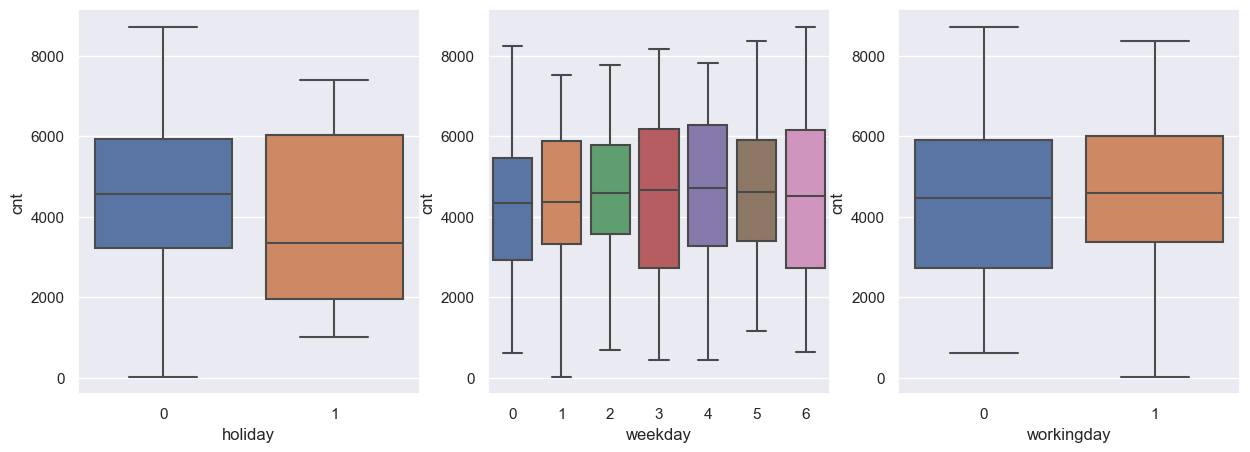

In [13]:
plt.subplot(1,3,1)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)
plt.subplot(1,3,2)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(1,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_bike)
plt.show()

### Data dictionary for reference - 
holiday - 0: no, 1: yes

 =======> min and median is lower on holidays
 
 weekday - 0 to 6 (6 and 0 is not a working day => 0 - Sunday to 6 - Saturday)
 
 =======> Median is almost similar on all days
 
 workingday - if day is neither weekend nor holiday is 1, otherwise is 0.
 
 =======> Median is almost similar on all days. 
 
 First and third plot say a similar story - 
 
 Non holiday and working days' min value is higher => more rentals in general 
 
 Holiday and non working days are different, though => weekend is influencing (?)

<Axes: >

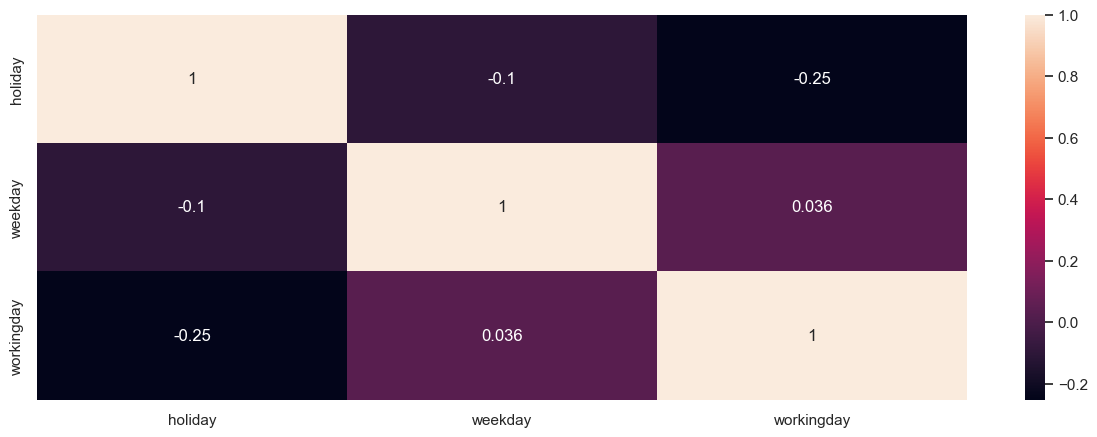

In [14]:
df_bike_eda = df_bike[['holiday', 'weekday', 'workingday']]
sns.heatmap(df_bike_eda.corr(), annot = True)

No notable correlation => weekends don't seem to influence

Can they be collinear without being correlated

Not dropping any of these columns

<Axes: xlabel='workingday', ylabel='cnt'>

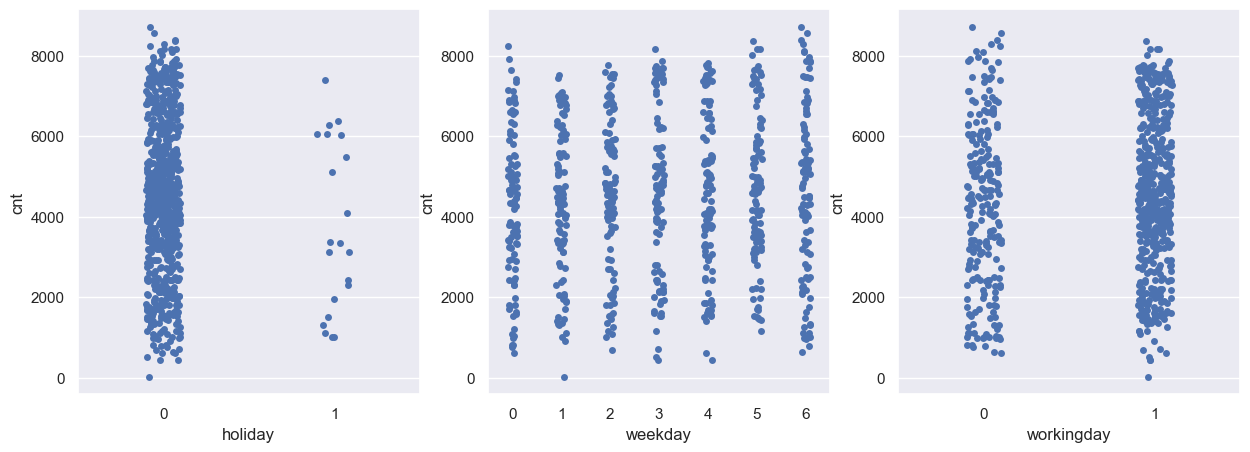

In [15]:
# Visualizing in a different way to ensure the patterns
plt.subplot(1,3,1)
sns.stripplot(x ='holiday', y ='cnt', data = df_bike, jitter = True, dodge = True)
plt.subplot(1,3,2)
sns.stripplot(x ='weekday', y ='cnt', data = df_bike, jitter = True, dodge = True)
plt.subplot(1,3,3)
sns.stripplot(x ='workingday', y ='cnt', data = df_bike, jitter = True, dodge = True)

### Data dictionary for reference - 
holiday - 0: no, 1: yes =======> lesser rentals on holidays

weekday - 0 to 6 (6 and 0 is not a working day => 0 - Sunday to 6 - Saturday) 

workingday - if day is neither weekend nor holiday is 1, otherwise is 0 =======> Lesser rentals on weekends and holidays

Result similar to box plot.

<Axes: >

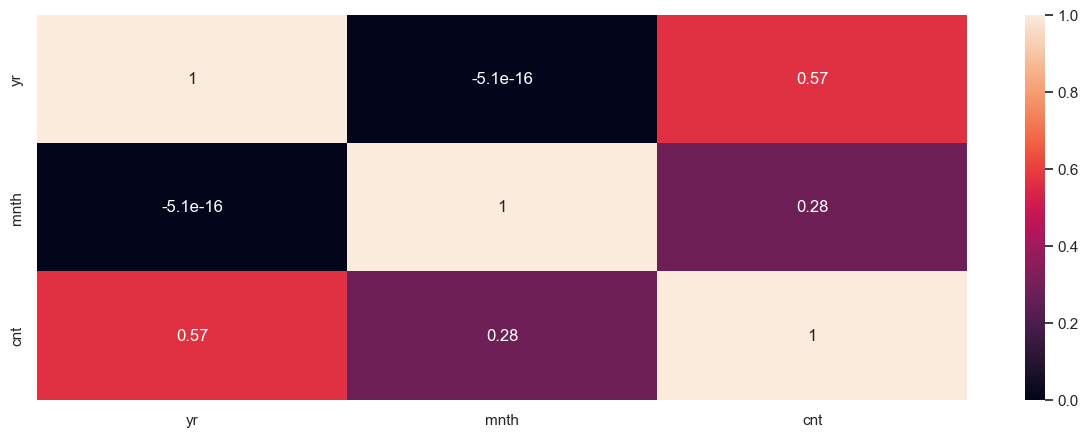

In [16]:
# dteday, yr, mnth
df_bike_eda = df_bike[['dteday', 'yr', 'mnth', 'cnt']]
sns.heatmap(df_bike_eda.corr(), annot = True)

Count has a decent positive correlation with Year 

=> riders increased with year 

=> overall positive growth

In [17]:
# Drop 'instant' and 'temp'
df_bike = df_bike.drop(['instant', 'dteday', 'temp'], axis=1)

<Axes: >

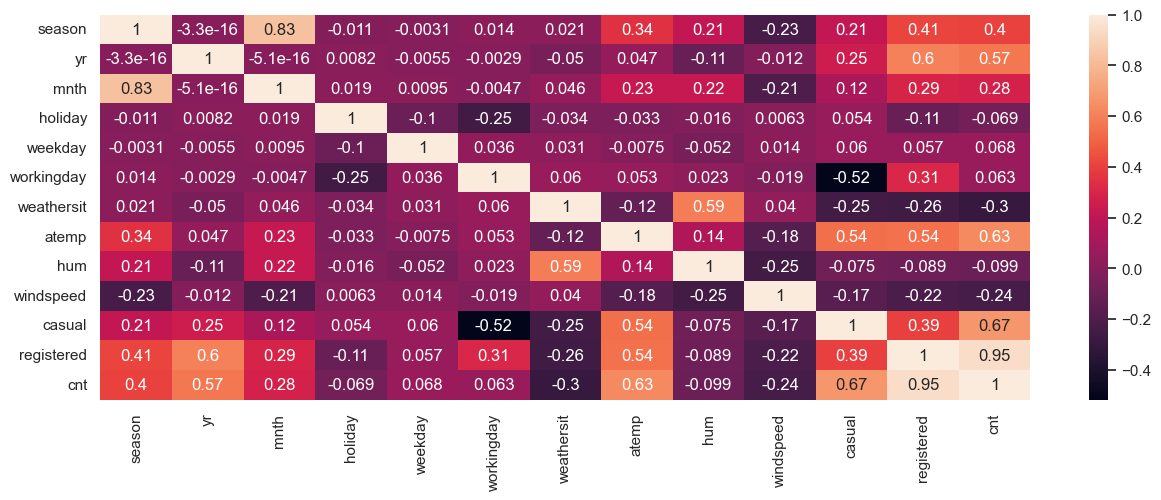

In [18]:
# Overall heatmap to recheck patterns
df_bike_eda = df_bike
sns.heatmap(df_bike_eda.corr(), annot = True)

###Observations - 

1. season and mnth, atemp, cnt (registered) - positively correlated

2. yr and cnt are correlated - growth is seen

3. mnth and atemp

4. holiday, weekday and workingday has no meaningful correlation except 
   that registered users seem to ride more on working day (weak positive correlation)
    
5. weathersit and hum - good positive correlation (weather gets worse, humidity increases)

6. atemp correlates with cnt (registered and casual) It correlates with mnth and season as well

7. registered and cnt has almost perfect positive correlation (can we drop casual 
   and registered both and consider only cnt)

###Important Features/ Variables only with correlation data -
1. season (0.4)

2. yr (0.57)

3. atemp (0.63)

4. mnth (0.28)

5. windspeed (-0.24)

6. casual and registered (0.67 & 0.95)

This needs to be compared with the derived coefficients

In [19]:
# Copying data frame
bike = df_bike.copy()
bike.shape

(730, 13)

In [20]:
bike.head()

season  yr  mnth  holiday  weekday  workingday  weathersit     atemp  \
0       1   0     1        0        6           0           2  18.18125   
1       1   0     1        0        0           0           2  17.68695   
2       1   0     1        0        1           1           1   9.47025   
3       1   0     1        0        2           1           1  10.60610   
4       1   0     1        0        3           1           1  11.46350   

       hum  windspeed  casual  registered   cnt  
0  80.5833  10.749882     331         654   985  
1  69.6087  16.652113     131         670   801  
2  43.7273  16.636703     120        1229  1349  
3  59.0435  10.739832     108        1454  1562  
4  43.6957  12.522300      82        1518  1600

In [21]:
# Map Categorical Values to String
varlist =  ['season']
def season_map(x):
    return x.map({'1': 'spring', '2': 'summer', '3': 'fall', '4': 'winter'})
bike['season'] = bike['season'].astype("string")
bike[varlist] = bike[varlist].apply(season_map)
bike.head()

season  yr  mnth  holiday  weekday  workingday  weathersit     atemp  \
0  spring   0     1        0        6           0           2  18.18125   
1  spring   0     1        0        0           0           2  17.68695   
2  spring   0     1        0        1           1           1   9.47025   
3  spring   0     1        0        2           1           1  10.60610   
4  spring   0     1        0        3           1           1  11.46350   

       hum  windspeed  casual  registered   cnt  
0  80.5833  10.749882     331         654   985  
1  69.6087  16.652113     131         670   801  
2  43.7273  16.636703     120        1229  1349  
3  59.0435  10.739832     108        1454  1562  
4  43.6957  12.522300      82        1518  1600

In [22]:
# Map Categorical Values to String
varlist =  ['weathersit']
def weathersit_map(x):
    return x.map({'1': 'clear', '2': 'cloudy', '3': 'lightsnow', '4': 'heavyrain'})
bike['weathersit'] = bike['weathersit'].astype("string")
bike[varlist] = bike[varlist].apply(weathersit_map)
bike.head()

season  yr  mnth  holiday  weekday  workingday weathersit     atemp  \
0  spring   0     1        0        6           0     cloudy  18.18125   
1  spring   0     1        0        0           0     cloudy  17.68695   
2  spring   0     1        0        1           1      clear   9.47025   
3  spring   0     1        0        2           1      clear  10.60610   
4  spring   0     1        0        3           1      clear  11.46350   

       hum  windspeed  casual  registered   cnt  
0  80.5833  10.749882     331         654   985  
1  69.6087  16.652113     131         670   801  
2  43.7273  16.636703     120        1229  1349  
3  59.0435  10.739832     108        1454  1562  
4  43.6957  12.522300      82        1518  1600

In [23]:
# Create Dummy variables for season (categorical), weathersit (even if it is ranked, it is categorical)
season_d = pd.get_dummies(bike['season'], drop_first = True)
bike = pd.concat([bike, season_d], axis = 1)
weathersit_d = pd.get_dummies(bike['weathersit'], drop_first = True)
bike = pd.concat([bike, weathersit_d], axis = 1)
bike.head()

season  yr  mnth  holiday  weekday  workingday weathersit     atemp  \
0  spring   0     1        0        6           0     cloudy  18.18125   
1  spring   0     1        0        0           0     cloudy  17.68695   
2  spring   0     1        0        1           1      clear   9.47025   
3  spring   0     1        0        2           1      clear  10.60610   
4  spring   0     1        0        3           1      clear  11.46350   

       hum  windspeed  casual  registered   cnt  spring  summer  winter  \
0  80.5833  10.749882     331         654   985       1       0       0   
1  69.6087  16.652113     131         670   801       1       0       0   
2  43.7273  16.636703     120        1229  1349       1       0       0   
3  59.0435  10.739832     108        1454  1562       1       0       0   
4  43.6957  12.522300      82        1518  1600       1       0       0   

   cloudy  lightsnow  
0       1          0  
1       1          0  
2       0          0  
3       0          0  
4       0          0

there is no rider data when the weathersit is 4

=> Only 2 dummy variables are created to represent below mapping
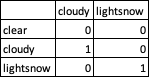

For season, below mapping is getting created
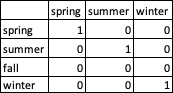

In [24]:
bike.head()

season  yr  mnth  holiday  weekday  workingday weathersit     atemp  \
0  spring   0     1        0        6           0     cloudy  18.18125   
1  spring   0     1        0        0           0     cloudy  17.68695   
2  spring   0     1        0        1           1      clear   9.47025   
3  spring   0     1        0        2           1      clear  10.60610   
4  spring   0     1        0        3           1      clear  11.46350   

       hum  windspeed  casual  registered   cnt  spring  summer  winter  \
0  80.5833  10.749882     331         654   985       1       0       0   
1  69.6087  16.652113     131         670   801       1       0       0   
2  43.7273  16.636703     120        1229  1349       1       0       0   
3  59.0435  10.739832     108        1454  1562       1       0       0   
4  43.6957  12.522300      82        1518  1600       1       0       0   

   cloudy  lightsnow  
0       1          0  
1       1          0  
2       0          0  
3       0          0  
4       0          0

In [25]:
# weekday is a categorical variable, this will need dummy variables as well
# map and drop the weekday variable
varlist =  ['weekday']
def weekday_map(x):
    return x.map({'0': 'sun', '1': 'mon', '2': 'tues', '3': 'wed', '4': 'thur', '5': 'fri', '6': 'sat'})
bike['weekday'] = bike['weekday'].astype("string")
bike[varlist] = bike[varlist].apply(weekday_map)
weekday_d = pd.get_dummies(bike['weekday'], drop_first = True)
bike = pd.concat([bike, weekday_d], axis = 1)
#bike = bike.drop(['weekday'], axis=1)
bike.head()

season  yr  mnth  holiday weekday  workingday weathersit     atemp  \
0  spring   0     1        0     sat           0     cloudy  18.18125   
1  spring   0     1        0     sun           0     cloudy  17.68695   
2  spring   0     1        0     mon           1      clear   9.47025   
3  spring   0     1        0    tues           1      clear  10.60610   
4  spring   0     1        0     wed           1      clear  11.46350   

       hum  windspeed  ...  summer  winter  cloudy  lightsnow  mon  sat  sun  \
0  80.5833  10.749882  ...       0       0       1          0    0    1    0   
1  69.6087  16.652113  ...       0       0       1          0    0    0    1   
2  43.7273  16.636703  ...       0       0       0          0    1    0    0   
3  59.0435  10.739832  ...       0       0       0          0    0    0    0   
4  43.6957  12.522300  ...       0       0       0          0    0    0    0   

   thur  tues  wed  
0     0     0    0  
1     0     0    0  
2     0     0    0  
3     0     1    0  
4     0     0    1  

[5 rows x 24 columns]

<Axes: >

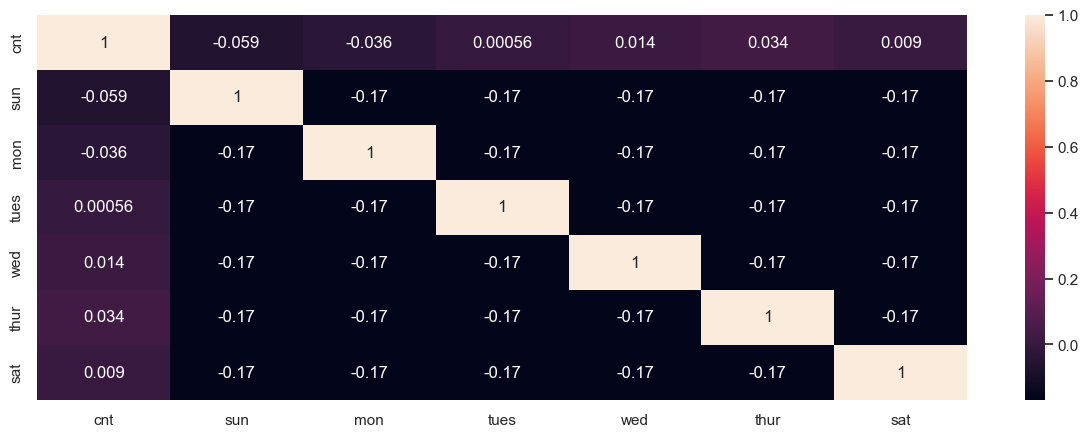

In [26]:
# Check if any correlation exists between the days of the week
varlist = ['cnt','sun','mon','tues','wed','thur','sat']
bike_weekdays = bike[varlist]
sns.heatmap(bike_weekdays.corr(), annot = True)

No strong correlation among weekdays and with cnt. 

In [27]:
# month and yr is also a categorical feature
varlist =  ['yr']
def yr_map(x):
    return x.map({'0': '2018', '1': '2019'})
bike['yr'] = bike['yr'].astype("string")
bike[varlist] = bike[varlist].apply(yr_map)
yr_d = pd.get_dummies(bike['yr'], drop_first = True)
bike = pd.concat([bike, yr_d], axis = 1)
bike.head()

season    yr  mnth  holiday weekday  workingday weathersit     atemp  \
0  spring  2018     1        0     sat           0     cloudy  18.18125   
1  spring  2018     1        0     sun           0     cloudy  17.68695   
2  spring  2018     1        0     mon           1      clear   9.47025   
3  spring  2018     1        0    tues           1      clear  10.60610   
4  spring  2018     1        0     wed           1      clear  11.46350   

       hum  windspeed  ...  winter  cloudy  lightsnow  mon  sat  sun  thur  \
0  80.5833  10.749882  ...       0       1          0    0    1    0     0   
1  69.6087  16.652113  ...       0       1          0    0    0    1     0   
2  43.7273  16.636703  ...       0       0          0    1    0    0     0   
3  59.0435  10.739832  ...       0       0          0    0    0    0     0   
4  43.6957  12.522300  ...       0       0          0    0    0    0     0   

   tues  wed  2019  
0     0    0     0  
1     0    0     0  
2     0    0     0  
3     1    0     0  
4     0    1     0  

[5 rows x 25 columns]

In [28]:
varlist =  ['mnth']
def mnth_map(x):
    return x.map({'1': 'jan', '2': 'feb',
                  '3': 'mar', '4': 'apr',
                  '5': 'may', '6': 'jun',
                  '7': 'jul', '8': 'aug',
                  '9': 'sep', '10': 'oct',
                  '11': 'nov', '12': 'dec',})
bike['mnth'] = bike['mnth'].astype("string")
bike[varlist] = bike[varlist].apply(mnth_map)
mnth_d = pd.get_dummies(bike['mnth'], drop_first = True)
bike = pd.concat([bike, mnth_d], axis = 1)
bike.head()

season    yr mnth  holiday weekday  workingday weathersit     atemp  \
0  spring  2018  jan        0     sat           0     cloudy  18.18125   
1  spring  2018  jan        0     sun           0     cloudy  17.68695   
2  spring  2018  jan        0     mon           1      clear   9.47025   
3  spring  2018  jan        0    tues           1      clear  10.60610   
4  spring  2018  jan        0     wed           1      clear  11.46350   

       hum  windspeed  ...  dec  feb  jan  jul  jun  mar  may  nov  oct  sep  
0  80.5833  10.749882  ...    0    0    1    0    0    0    0    0    0    0  
1  69.6087  16.652113  ...    0    0    1    0    0    0    0    0    0    0  
2  43.7273  16.636703  ...    0    0    1    0    0    0    0    0    0    0  
3  59.0435  10.739832  ...    0    0    1    0    0    0    0    0    0    0  
4  43.6957  12.522300  ...    0    0    1    0    0    0    0    0    0    0  

[5 rows x 36 columns]

<Axes: >

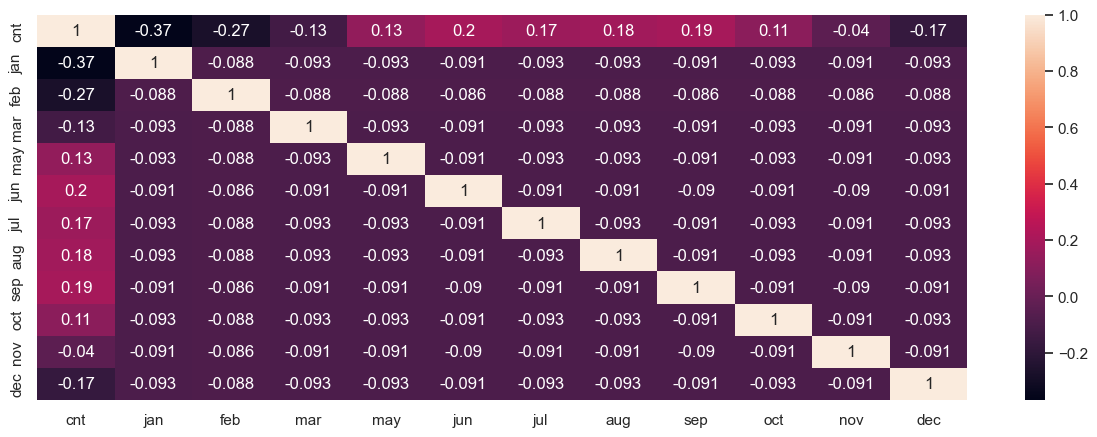

In [29]:
# Check if any correlation exists between the months of the year
varlist = ['cnt','jan','feb','mar','may','jun','jul','aug','sep','oct','nov','dec']
bike_months = bike[varlist]
sns.heatmap(bike_months.corr(), annot = True)

No strong correlation among months and with cnt

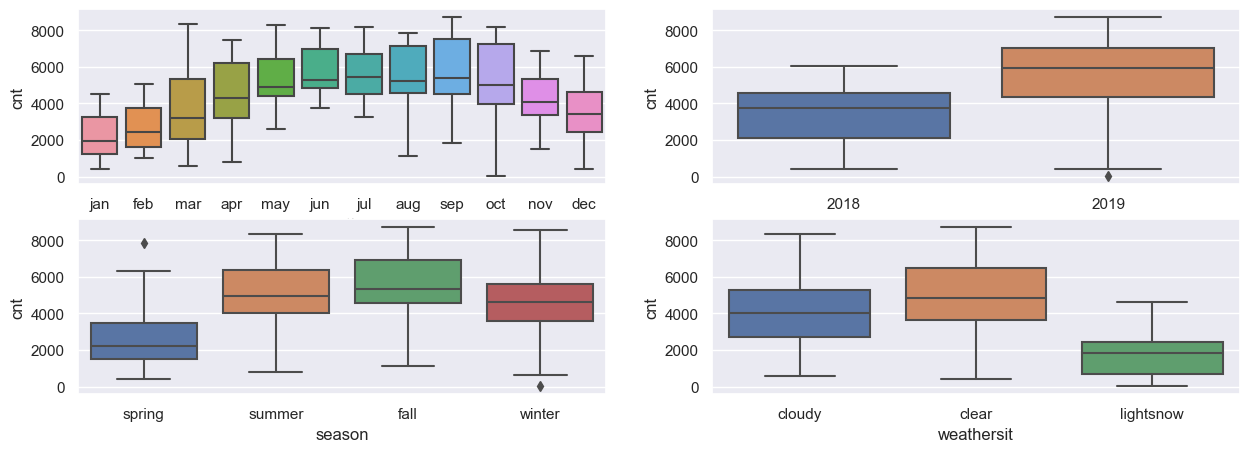

In [30]:
plt.subplot(2,2,1)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(2,2,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.subplot(2,2,3)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(2,2,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.show()

There is a pattern in months (Apr-Oct)

There is an increase with year

Summer and Fall sees more use

Clear weather sees more use

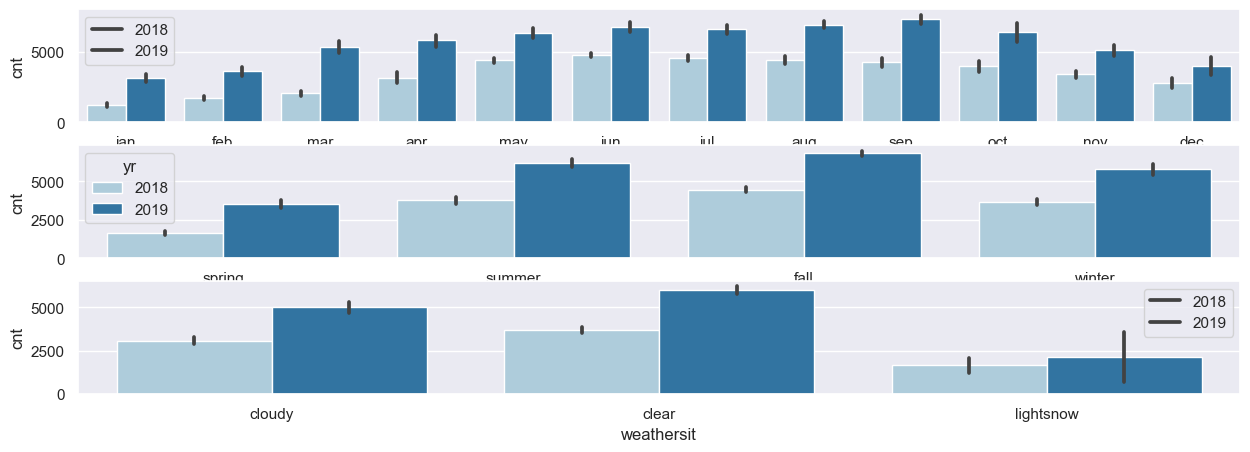

In [31]:
plt.subplot(3,1,1)
sns.barplot(x = 'mnth',y = 'cnt', data = bike, hue='yr',palette='Paired')
plt.legend(labels=['2018', '2019'])
plt.subplot(3,1,2)
sns.barplot(x = 'season',y = 'cnt', data = bike, hue='yr',palette='Paired')
plt.subplot(3,1,3)
sns.barplot(x = 'weathersit',y = 'cnt', data = bike, hue='yr',palette='Paired')
plt.legend(labels=['2018', '2019'])
plt.show()

Similar patterns as above. Not repeating for other fetures.

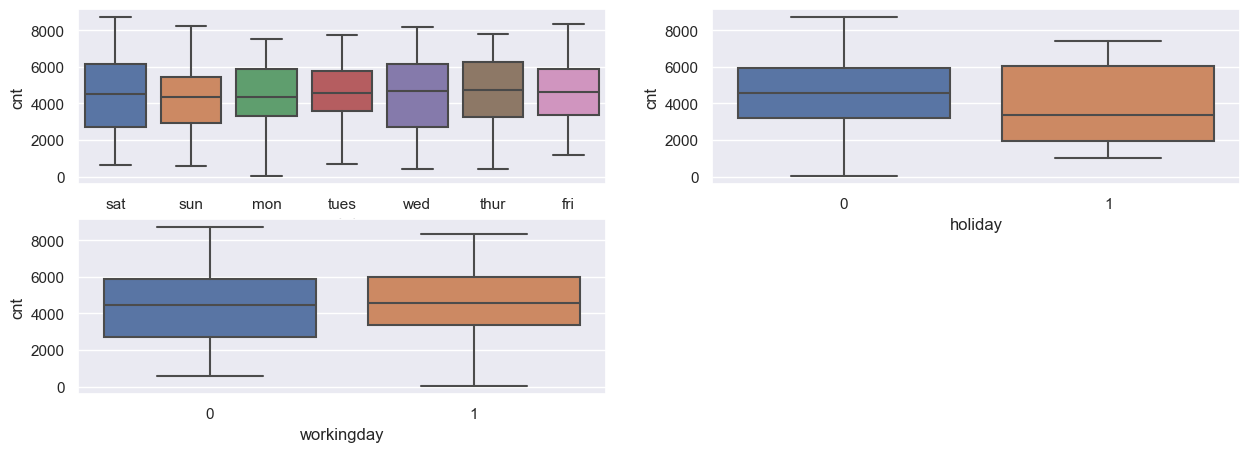

In [32]:
plt.subplot(2,2,1)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(2,2,2)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(2,2,3)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.show()

Slight variations but no clear pattern

In [33]:
bike = bike.drop(['mnth','yr','season','weathersit','weekday'], axis=1)
bike.head()

holiday  workingday     atemp      hum  windspeed  casual  registered  \
0        0           0  18.18125  80.5833  10.749882     331         654   
1        0           0  17.68695  69.6087  16.652113     131         670   
2        0           1   9.47025  43.7273  16.636703     120        1229   
3        0           1  10.60610  59.0435  10.739832     108        1454   
4        0           1  11.46350  43.6957  12.522300      82        1518   

    cnt  spring  summer  ...  dec  feb  jan  jul  jun  mar  may  nov  oct  sep  
0   985       1       0  ...    0    0    1    0    0    0    0    0    0    0  
1   801       1       0  ...    0    0    1    0    0    0    0    0    0    0  
2  1349       1       0  ...    0    0    1    0    0    0    0    0    0    0  
3  1562       1       0  ...    0    0    1    0    0    0    0    0    0    0  
4  1600       1       0  ...    0    0    1    0    0    0    0    0    0    0  

[5 rows x 31 columns]

In [34]:
bike_mlr = bike.copy()

In [35]:
# casual and registered users dont make sense in predicting the cnt, 
# also cnt represents both variables completely (sum)
bike_mlr = bike_mlr.drop(['casual','registered'], axis=1)

In [36]:
# Split the dataset
df_train, df_test = train_test_split(bike_mlr, train_size = 0.7, test_size = 0.3, random_state = 100)

In [37]:
# Scale the dataset
scaler = MinMaxScaler()
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

holiday  workingday     atemp       hum  windspeed       cnt  spring  \
653        0           1  0.501133  0.575354   0.300794  0.864243       0   
576        0           1  0.766351  0.725633   0.264686  0.827658       0   
426        0           0  0.438975  0.640189   0.255342  0.465255       1   
728        0           0  0.200348  0.498067   0.663106  0.204096       1   
482        0           0  0.391735  0.504508   0.188475  0.482973       0   

     summer  winter  cloudy  ...  dec  feb  jan  jul  jun  mar  may  nov  oct  \
653       0       1       0  ...    0    0    0    0    0    0    0    0    1   
576       0       0       0  ...    0    0    0    1    0    0    0    0    0   
426       0       0       1  ...    0    0    0    0    0    1    0    0    0   
728       0       0       0  ...    1    0    0    0    0    0    0    0    0   
482       1       0       1  ...    0    0    0    0    0    0    0    0    0   

     sep  
653    0  
576    0  
426    0  
728    0  
482    0  

[5 rows x 29 columns]

In [38]:
# Split the independent variable and the dependent variables
y_train = df_train.pop('cnt')
X_train = df_train

In [39]:
# Using SciKit Learn for MLR
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 6),
 ('winter', True, 1),
 ('cloudy', True, 1),
 ('lightsnow', True, 1),
 ('mon', False, 10),
 ('sat', True, 1),
 ('sun', True, 1),
 ('thur', False, 11),
 ('tues', False, 9),
 ('wed', False, 12),
 ('2019', True, 1),
 ('aug', False, 7),
 ('dec', False, 3),
 ('feb', False, 4),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 8),
 ('mar', False, 14),
 ('may', False, 5),
 ('nov', False, 2),
 ('oct', False, 13),
 ('sep', True, 1)]

In [40]:
col = X_train.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', 'cloudy', 'lightsnow', 'sat', 'sun', '2019', 'jan', 'jul',
       'sep'],
      dtype='object')

In [41]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]
# Add constant for statsmodel
X_train_rfe = sm.add_constant(X_train_rfe)
# Fit the model 
lm = sm.OLS(y_train,X_train_rfe).fit() 
# Statistical summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          1.66e-188
Time:                        15:21:46   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2535      0.026      9.914      0.0

There is a multicollinearity problem 

Drop variables to see if Cond. No. improves. 1.11e+15 is high.

holiday is insignificant (0.907 > 0.05)

In [42]:
X_train_new = X_train_rfe.drop(["holiday"], axis = 1)
X_train_lm = sm.add_constant(X_train_new)
lm1 = sm.OLS(y_train,X_train_lm).fit()   
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          1.66e-188
Time:                        15:21:46   Log-Likelihood:                 510.32
No. Observations:                 510   AIC:                            -990.6
Df Residuals:                     495   BIC:                            -927.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2510      0.040      6.252      0.0

In [43]:
X_train_new.columns

Index(['const', 'workingday', 'atemp', 'hum', 'windspeed', 'spring', 'winter',
       'cloudy', 'lightsnow', 'sat', 'sun', '2019', 'jan', 'jul', 'sep'],
      dtype='object')

In [44]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
0        const  100.81
1   workingday    9.07
9          sat    6.06
10         sun    5.74
2        atemp    3.11
5       spring    2.66
3          hum    1.91
6       winter    1.75
7       cloudy    1.57
12         jan    1.56
13         jul    1.30
8    lightsnow    1.25
4    windspeed    1.20
14         sep    1.11
11        2019    1.03

Multicollinearity exists - hum, atemp, workingday > 5

Drop one by one and re-check

In [45]:
X_train_new = X_train_new.drop(["hum"], axis = 1)
X_train_lm = sm.add_constant(X_train_new)
lm2 = sm.OLS(y_train,X_train_lm).fit()   
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.6
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          1.51e-186
Time:                        15:21:46   Log-Likelihood:                 502.89
No. Observations:                 510   AIC:                            -977.8
Df Residuals:                     496   BIC:                            -918.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1745      0.035      4.946      0.0

In [46]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0        const  75.79
1   workingday   9.07
8          sat   6.06
9          sun   5.74
2        atemp   2.92
4       spring   2.65
5       winter   1.68
11         jan   1.55
12         jul   1.28
3    windspeed   1.12
13         sep   1.10
6       cloudy   1.05
7    lightsnow   1.05
10        2019   1.02

In [47]:
X_train_new = X_train_new.drop(["workingday"], axis = 1)
X_train_lm = sm.add_constant(X_train_new)
lm3 = sm.OLS(y_train,X_train_lm).fit()  
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     207.1
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          1.35e-184
Time:                        15:21:46   Log-Likelihood:                 495.47
No. Observations:                 510   AIC:                            -964.9
Df Residuals:                     497   BIC:                            -909.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2710      0.025     10.839      0.0

In [48]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0       const  37.05
1       atemp   2.92
3      spring   2.65
4      winter   1.68
10        jan   1.55
11        jul   1.28
2   windspeed   1.12
12        sep   1.10
5      cloudy   1.05
6   lightsnow   1.05
7         sat   1.04
8         sun   1.04
9        2019   1.02

sat became insignificant in lm3

In [49]:
X_train_new = X_train_new.drop(["sat"], axis = 1)
X_train_lm = sm.add_constant(X_train_new)
lm4 = sm.OLS(y_train,X_train_lm).fit()   
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     225.5
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          2.14e-185
Time:                        15:21:46   Log-Likelihood:                 494.56
No. Observations:                 510   AIC:                            -965.1
Df Residuals:                     498   BIC:                            -914.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2738      0.025     10.979      0.0

In [50]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0       const  36.79
1       atemp   2.92
3      spring   2.65
4      winter   1.68
9         jan   1.55
10        jul   1.28
2   windspeed   1.12
11        sep   1.10
5      cloudy   1.05
6   lightsnow   1.05
8        2019   1.02
7         sun   1.01

In [51]:
# Residual Analysis
y_train_pred = lm4.predict(X_train_lm)                  

In [52]:
# Mean of residuals 
residuals = y_train - y_train_pred
residuals_mean = np.mean(residuals)
residuals_mean

-4.111743625317639e-15

Assumptions of MLR - near 0 mean for residuals satisfied

<Axes: >

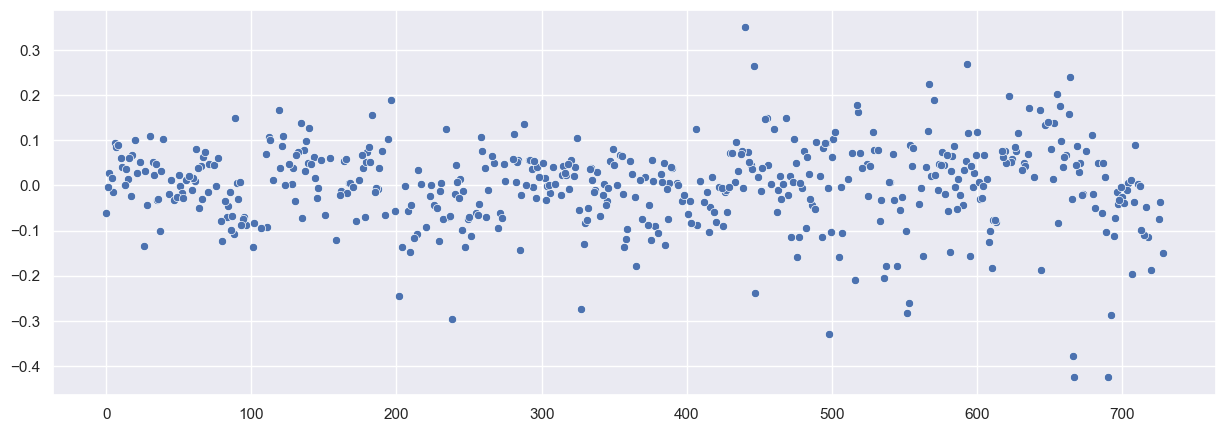

In [53]:
sns.scatterplot(y_train - y_train_pred)

No visible pattern in residuals => Homoscedasticity assumption is true

<Axes: ylabel='Density'>

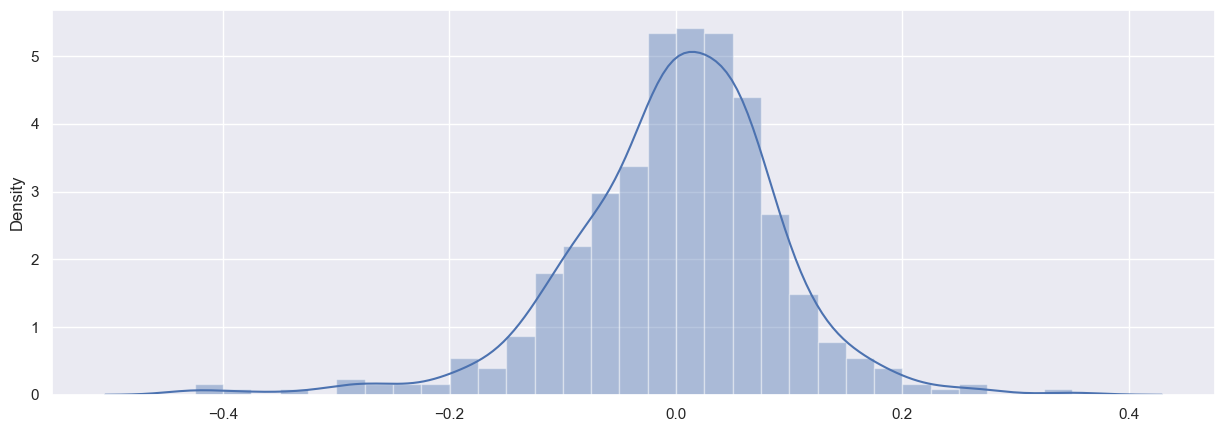

In [54]:
# Plot error terms 
fig = plt.figure()
sns.distplot((y_train - y_train_pred)) 

Evaluate model - errors normally distributed

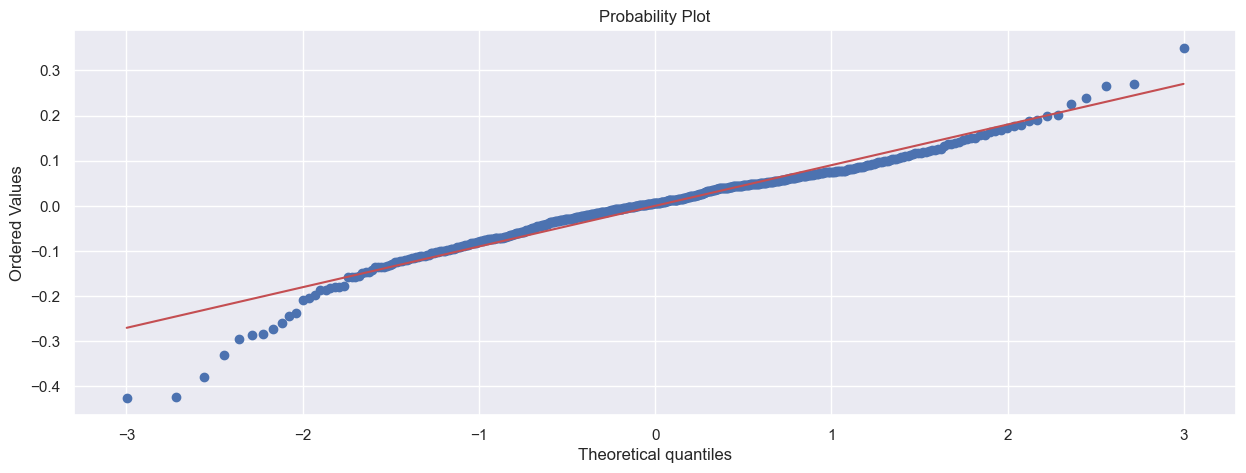

In [55]:
# QQ Plots for residuals (2 datasets are similar or not? -> plotting residuals)
stats.probplot((y_train - y_train_pred), plot=plt)
plt.show()

Straight line implies a normal distribution of residuals => model evaluated to be ok

In [56]:
# Scaling - Transform the test data
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

holiday  workingday     atemp       hum  windspeed       cnt  spring  \
184        1           0  0.769660  0.657364   0.084219  0.692706       0   
535        0           1  0.842587  0.610133   0.153728  0.712034       0   
299        0           1  0.496145  0.837699   0.334206  0.303382       0   
221        0           1  0.795343  0.437098   0.339570  0.547400       0   
152        0           1  0.741471  0.314298   0.537414  0.569029       0   

     summer  winter  cloudy  ...  dec  feb  jan  jul  jun  mar  may  nov  oct  \
184       0       0       1  ...    0    0    0    1    0    0    0    0    0   
535       1       0       0  ...    0    0    0    0    1    0    0    0    0   
299       0       1       1  ...    0    0    0    0    0    0    0    0    1   
221       0       0       0  ...    0    0    0    0    0    0    0    0    0   
152       1       0       0  ...    0    0    0    0    1    0    0    0    0   

     sep  
184    0  
535    0  
299    0  
221    0  
152    0  

[5 rows x 29 columns]

In [57]:
df_test.describe()

holiday  workingday       atemp         hum   windspeed         cnt  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.036530    0.698630    0.532991    0.638508    0.313350    0.520592   
std      0.188034    0.459904    0.217888    0.148974    0.159947    0.218435   
min      0.000000    0.000000    0.025950    0.261915   -0.042808    0.048205   
25%      0.000000    0.000000    0.344751    0.527265    0.198517    0.377531   
50%      0.000000    1.000000    0.549198    0.627737    0.299459    0.524275   
75%      0.000000    1.000000    0.714132    0.743928    0.403048    0.672745   
max      1.000000    1.000000    0.980934    1.002146    0.807474    0.963300   

           spring      summer      winter      cloudy  ...         dec  \
count  219.000000  219.000000  219.000000  219.000000  ...  219.000000   
mean     0.255708    0.264840    0.232877    0.319635  ...    0.086758   
std      0.437258    0.442259    0.423633    0.467403  ...    0.282125   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
75%      1.000000    1.000000    0.000000    1.000000  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              feb         jan         jul         jun         mar         may  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.100457    0.077626    0.105023    0.095890    0.054795    0.086758   
std      0.301297    0.268194    0.307285    0.295115    0.228100    0.282125   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              nov         oct         sep  
count  219.000000  219.000000  219.000000  
mean     0.073059    0.082192    0.086758  
std      0.260830    0.275286    0.282125  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000  

[8 rows x 29 columns]

In [58]:
y_test = df_test.pop('cnt')
X_test = df_test
# Add Constant
X_test_lm = sm.add_constant(X_test)

In [59]:
# Remove features we removed from Training dataset (holiday, hum, workingday, sat)
X_test_lm = X_test_lm.drop(["holiday", "hum", "workingday", "sat"], axis = 1)

In [60]:
X_test_lm = X_test_lm.drop(['summer', 'mon', 'thur', 'tues', 'wed', 'aug', 'dec','feb','jun', 'mar', 'may', 'nov', 'oct'], axis = 1)

In [61]:
X_test_lm.columns

Index(['const', 'atemp', 'windspeed', 'spring', 'winter', 'cloudy',
       'lightsnow', 'sun', '2019', 'jan', 'jul', 'sep'],
      dtype='object')

In [62]:
X_train_lm.columns

Index(['const', 'atemp', 'windspeed', 'spring', 'winter', 'cloudy',
       'lightsnow', 'sun', '2019', 'jan', 'jul', 'sep'],
      dtype='object')

In [63]:
# Make predictions for the test set
y_test_pred = lm4.predict(X_test_lm)

In [64]:
# Evaluate the model
r2_score(y_true = y_test, y_pred = y_test_pred)

0.8067922278856641

83.3% from Train set and 80.7% from test set

=> Model is generalising well

<Axes: ylabel='Density'>

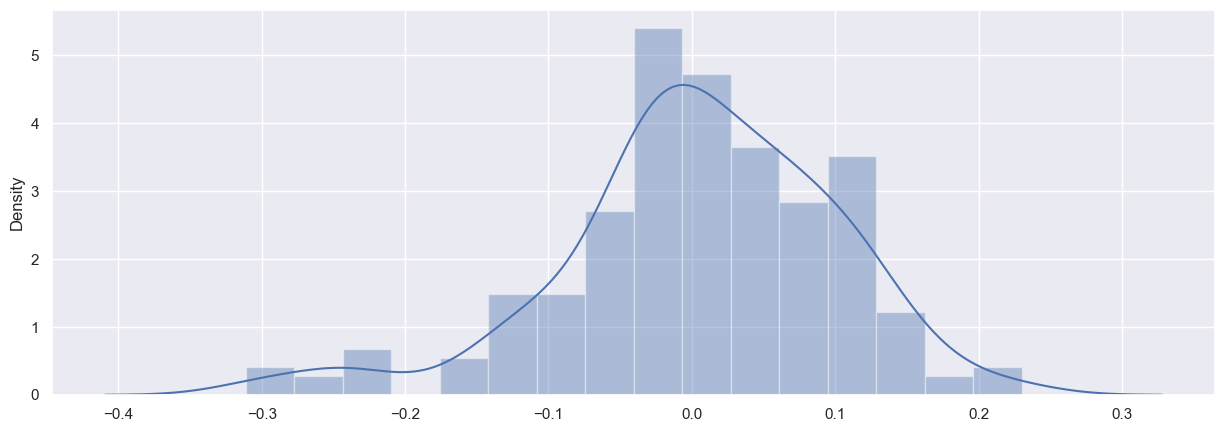

In [65]:
# Plot error terms
fig = plt.figure()
sns.distplot((y_test - y_test_pred))  

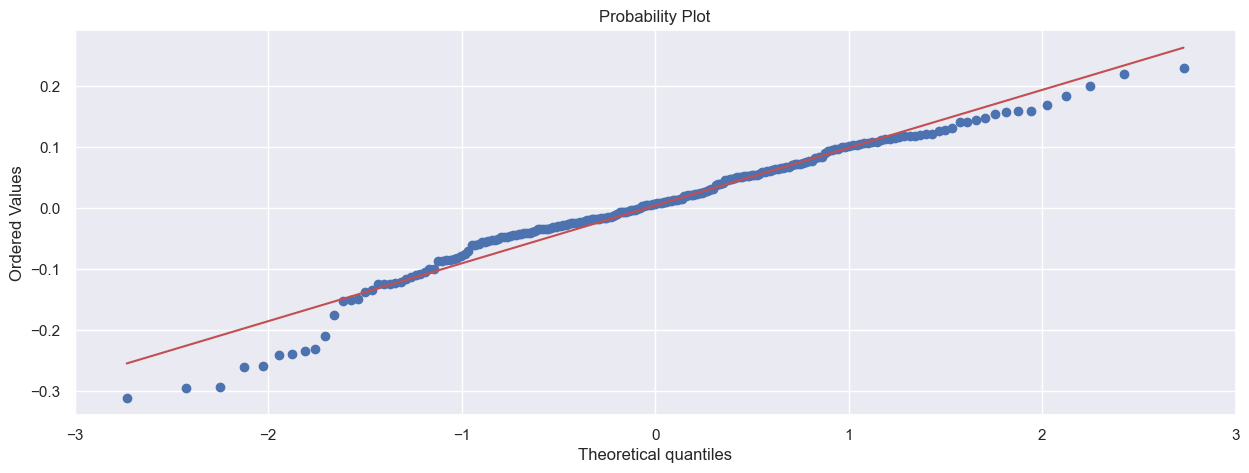

In [66]:
# QQ Plots for residuals
stats.probplot((y_test - y_test_pred), plot=plt)
plt.show()

In [67]:
lm4.params

const        0.273819
atemp        0.445179
windspeed   -0.136352
spring      -0.109412
winter       0.034287
cloudy      -0.080750
lightsnow   -0.284062
sun         -0.045458
2019         0.236147
jan         -0.044288
jul         -0.061578
sep          0.055855
dtype: float64

### Hypothesis Testing for MLR

Null Hypothesis:Bi eq 0
    
Alternate Hypothesis:Bi ne 0
    
Based on lm4.params, rejecting the null hypothesis => all selected coefficients are significant

### Model Equation
 cnt = 0.273819 + (0.445179*atemp) - (0.136352*windspeed) - (0.109412*spring) + (0.034287*winter)
     - (0.080750*cloudy) - (0.284062*lightsnow) - (0.045458*sun) + (0.236147*2019) 
     - (0.044288*jan) - (0.061578*jul) + (0.055855*sep)

 => Simplifying to 5 features
 cnt = 0.273819 + (0.445179*atemp) + (0.236147*2019) - (0.284062*lightsnow) 
     - (0.136352*windspeed) - (0.109412*spring) - (0.080750*cloudy)

### Interpreting the model for the business case

- The business outlook for Boom Bikes is good. Even if there is no factor influence, the business will grow by 0.273819 units.

- For unit increase in Feeling Temperature, the bike rental will increase by 0.445179 units (Provision more bikes?)

- For unit increase in windspeed, the bike rental will fall by 0.136352 units (Add attractive offers/ discounts?)

- Every year, the rental will increase by 0.236147 units (plan for expansion?)

- Spring, light snow and cloudy weather negatively impacts rentals (provide attractive perks/ offers?)